<a href="https://colab.research.google.com/github/vasilijeIT23/PPPO_Age_Gender_Emotion_Detection/blob/main/pppo_gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import zipfile
import random
import shutil
from PIL import Image
from shutil import copyfile
import csv
from sklearn.metrics import confusion_matrix
import itertools

In [21]:
def unzip_file(zip_file_path, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the destination folder
        zip_ref.extractall(destination_folder)

def delete_folder_contents(folder_path):
    # Iterate through files and subfolders in the specified folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # Check if it's a file and delete it
        if os.path.isfile(item_path):
            os.remove(item_path)
        # Check if it's a subfolder and delete it recursively
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

def move_files_based_on_condition(source_folder, destination_folder, threshold):
    # Ensure the destination folder exists, create it if necessary
    os.makedirs(destination_folder, exist_ok=True)

    # Iterate through files in the source folder
    for filename in os.listdir(source_folder):
        source_path = os.path.join(source_folder, filename)

        # Extract the part of the filename before the first underscore
        first_part = filename.split('_')[0]

        try:
            # Convert the first part to an integer and check the condition
            if int(first_part) > threshold:
                # Move the file to the destination folder
                destination_path = os.path.join(destination_folder, filename)
                shutil.copy2(source_path, destination_path)
        except ValueError:
            # Handle the case where the first part is not a valid integer
            print(f"Ignored {filename} (not a valid format)")

def count_files_per_folder(root_folder):
    folder_file_count = 0

    for foldername, subfolders, filenames in os.walk(root_folder):
        file_count = len(filenames)
        folder_file_count += file_count

    return folder_file_count

def create_csv_with_labels(root_folder, output_csv_path):
    with open(output_csv_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['image_name', 'gender'])  # Header row

        # Iterate through files in the root folder
        for filename in os.listdir(root_folder):
            file_path = os.path.join(root_folder, filename)

            # Extract gender from the filename using underscores as splitting point
            gender = filename.split('_')[1] if '_' in filename else 'Unknown'

            # Write image name and gender to CSV file
            csv_writer.writerow([file_path, gender])

def shuffle_and_move_files(source_folder, destination_folder):
    # Ensure the destination folder exists, create it if necessary
    os.makedirs(destination_folder, exist_ok=True)

    # Get a list of all files in the source folder
    all_files = os.listdir(source_folder)

    # Shuffle the list of files
    random.shuffle(all_files)

    # Iterate through the shuffled files and move every second file
    for i, filename in enumerate(all_files):
        source_path = os.path.join(source_folder, filename)

        # Move every second file to the destination folder
        if i % 2 == 1:
            destination_path = os.path.join(destination_folder, filename)
            shutil.move(source_path, destination_path)

def convert_and_resize_images(source_folder, new_size=(100, 100)):
    # Iterate through files in the source folder
    for filename in os.listdir(source_folder):
        source_path = os.path.join(source_folder, filename)

        # Open the image
        img = Image.open(source_path)

        # Convert to grayscale
        grayscale_img = img.convert('L')

        # Resize the image
        resized_img = grayscale_img.resize(new_size)

        # Save the converted and resized image, overwriting the original
        resized_img.save(source_path)
        print(f"Converted and resized {filename}")

def split_and_copy_data(source_folder, train_destination, test_destination, test_size=0.2, random_state=42):
    # Ensure the destination folders exist, create them if necessary
    os.makedirs(train_destination, exist_ok=True)
    os.makedirs(test_destination, exist_ok=True)

    # Get a list of all files in the source folder
    all_files = [filename for filename in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, filename))]

    # Split the data into train and test sets
    train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=random_state)

    # Copy files to train destination folder
    for filename in train_files:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(train_destination, filename)
        copyfile(source_path, destination_path)
        print(f"Copied {filename} to {train_destination}")

    # Copy files to test destination folder
    for filename in test_files:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(test_destination, filename)
        copyfile(source_path, destination_path)
        print(f"Copied {filename} to {test_destination}")

def load_data_from_csv(train_csv_path, test_csv_path):
    # Load data from CSV files
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)

    # Extract file paths and labels for train set
    x_train_paths = train_df['image_name'].values
    y_train = train_df['gender'].values

    # Extract file paths and labels for test set
    x_test_paths = test_df['image_name'].values
    y_test = test_df['gender'].values

    return x_train_paths, y_train, x_test_paths, y_test

def load_images(file_paths):
    images = []
    for file_path in file_paths:
        img = Image.open(file_path)
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

def class_labels_reassign(gender):
    if gender == 0:
        return 0
    else:
      return 1

In [ ]:
# Specify the path to the zip file and the destination folder
zip_file_path = '/content/drive/MyDrive/UTKFace.zip'
destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/initial_data'

# Call the function to unzip the file
unzip_file(zip_file_path, destination_folder)

print("Unzipping completed.")

In [ ]:
# Specify the folder whose contents you want to delete
folder_to_empty = '/content/drive/MyDrive/PPPO/gender_detection/initial_data'

# Call the function to delete the contents of the folder
delete_folder_contents(folder_to_empty)

print(f"Contents of {folder_to_empty} deleted.")


Contents of /content/drive/MyDrive/PPPO/gender_detection/initial_data deleted.


In [ ]:
# Specify the source and destination folders
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/initial_data/UTKFace'
destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Set the threshold (default is 6)
threshold_value = 6

# Call the function to move files based on the condition
move_files_based_on_condition(source_folder, destination_folder, threshold_value)


In [2]:
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/initial_data/UTKFace'
destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

original_data_number = count_files_per_folder(source_folder)
stripped_data_number = count_files_per_folder(destination_folder)

print("Data with 6-year olds and younger: ", original_data_number)
print("Data without 6-year olds and younger: ", stripped_data_number)

Data with 6-year olds and younger:  23708
Data without 6-year olds and younger:  10607


In [ ]:
# Specify the root folder
root_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Specify the output CSV file path
output_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/metadata.csv'

# Call the function to create the CSV file with labels
create_csv_with_labels(root_folder, output_csv_path)

print(f"CSV file with labels created at: {output_csv_path}")


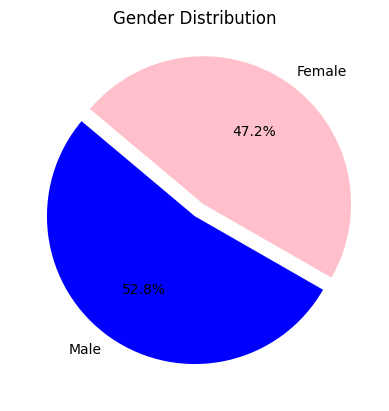

In [ ]:
# Specify the path to the CSV file
csv_file_path = '/content/drive/MyDrive/PPPO/gender_detection/metadata.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Count the occurrences of each gender
gender_counts = df['gender'].value_counts()

# Plotting the pie chart
labels = ['Male', 'Female']
colors = ['blue', 'pink']
explode = (0, 0.1)  # Explode the 'Female' slice for better visibility

plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Gender Distribution')
plt.show()


In [ ]:
# Specify the source and destination folders
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'
destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/leftover_files'

# Call the function to shuffle and move files
shuffle_and_move_files(source_folder, destination_folder)

print(f"Shuffling and moving completed.")


Shuffling and moving completed.


In [ ]:
# Specify the root folder
root_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Specify the output CSV file path
output_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/new_metadata.csv'

# Call the function to create the CSV file with labels
create_csv_with_labels(root_folder, output_csv_path)

print(f"CSV file with labels created at: {output_csv_path}")

CSV file with labels created at: /content/drive/MyDrive/PPPO/gender_detection/new_metadata.csv


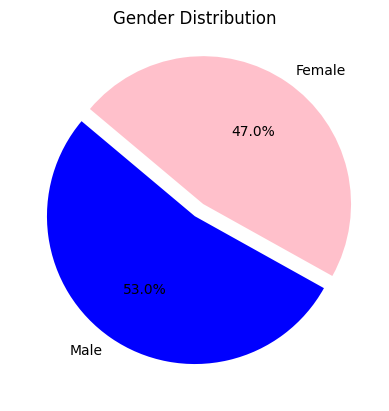

In [ ]:
# Specify the path to the CSV file
csv_file_path = '/content/drive/MyDrive/PPPO/gender_detection/new_metadata.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Count the occurrences of each gender
gender_counts = df['gender'].value_counts()

# Plotting the pie chart
labels = ['Male', 'Female']
colors = ['blue', 'pink']
explode = (0, 0.1)  # Explode the 'Female' slice for better visibility

plt.pie(gender_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Gender Distribution')
plt.show()

In [ ]:
# Specify the source folder
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Call the function to convert and resize images
convert_and_resize_images(source_folder)

print(f"Conversion and resizing completed.")


In [ ]:
# Specify the source folder
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Specify the destination folders for train and test sets
train_destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/train'
test_destination_folder = '/content/drive/MyDrive/PPPO/gender_detection/test'

# Call the function to split and copy the data
split_and_copy_data(source_folder, train_destination_folder, test_destination_folder)

print("Splitting and copying completed.")


In [ ]:
# Specify the source folder
source_folder = '/content/drive/MyDrive/PPPO/gender_detection/augmeted_data'

# Call the function to convert and resize images
convert_and_resize_images(source_folder)

print(f"Conversion and resizing completed.")


In [ ]:
# Specify the root folder
train_folder = '/content/drive/MyDrive/PPPO/gender_detection/train'
test_folder = '/content/drive/MyDrive/PPPO/gender_detection/test'

# Specify the output CSV file path
train_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/train.csv'
test_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/test.csv'

# Call the function to create the CSV file with labels
create_csv_with_labels(train_folder, train_csv_path)
create_csv_with_labels(test_folder, test_csv_path)

In [13]:
# Specify the paths to your train and test CSV files
train_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/train.csv'
test_csv_path = '/content/drive/MyDrive/PPPO/gender_detection/test.csv'

# Call the function to load data from CSV files
x_train_paths, y_train, x_test_paths, y_test = load_data_from_csv(train_csv_path, test_csv_path)

print(f"Total images: {len(x_train_paths) + len(x_test_paths)}")
print(f"Train set size: {len(x_train_paths)}")
print(f"Test set size: {len(x_test_paths)}")

x_train = load_images(x_train_paths)
x_test = load_images(x_test_paths)

print(x_train)
print(y_train)


Total images: 10607
Train set size: 8485
Test set size: 2122
[[[0.93333333 0.90588235 0.89019608 ... 0.41960784 0.36470588 0.32156863]
  [0.93333333 0.91372549 0.89019608 ... 0.41568627 0.37254902 0.34509804]
  [0.92156863 0.92156863 0.89411765 ... 0.41568627 0.38039216 0.36470588]
  ...
  [0.23921569 0.22352941 0.2        ... 0.94509804 0.94509804 0.92156863]
  [0.20784314 0.19215686 0.16470588 ... 0.94509804 0.92156863 0.89411765]
  [0.16862745 0.15294118 0.12941176 ... 0.9254902  0.89803922 0.88627451]]

 [[0.24313725 0.20392157 0.16078431 ... 0.53333333 0.52156863 0.50588235]
  [0.21176471 0.20784314 0.17647059 ... 0.5254902  0.54117647 0.54117647]
  [0.17647059 0.21568627 0.20392157 ... 0.53333333 0.58823529 0.63921569]
  ...
  [0.14901961 0.15294118 0.15294118 ... 0.96470588 0.9372549  0.90196078]
  [0.14509804 0.14509804 0.14901961 ... 0.96470588 0.9372549  0.89803922]
  [0.14117647 0.14117647 0.14117647 ... 0.96470588 0.93333333 0.89019608]]

 [[0.10980392 0.11372549 0.11764706

In [14]:
input = Input(shape = (100,100,1))
conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)
conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)
conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)
conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128,activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(2,activation="sigmoid")(drop_1)

# Model compile
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
model.summary()

# Model Checkpoint
model_path='/content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

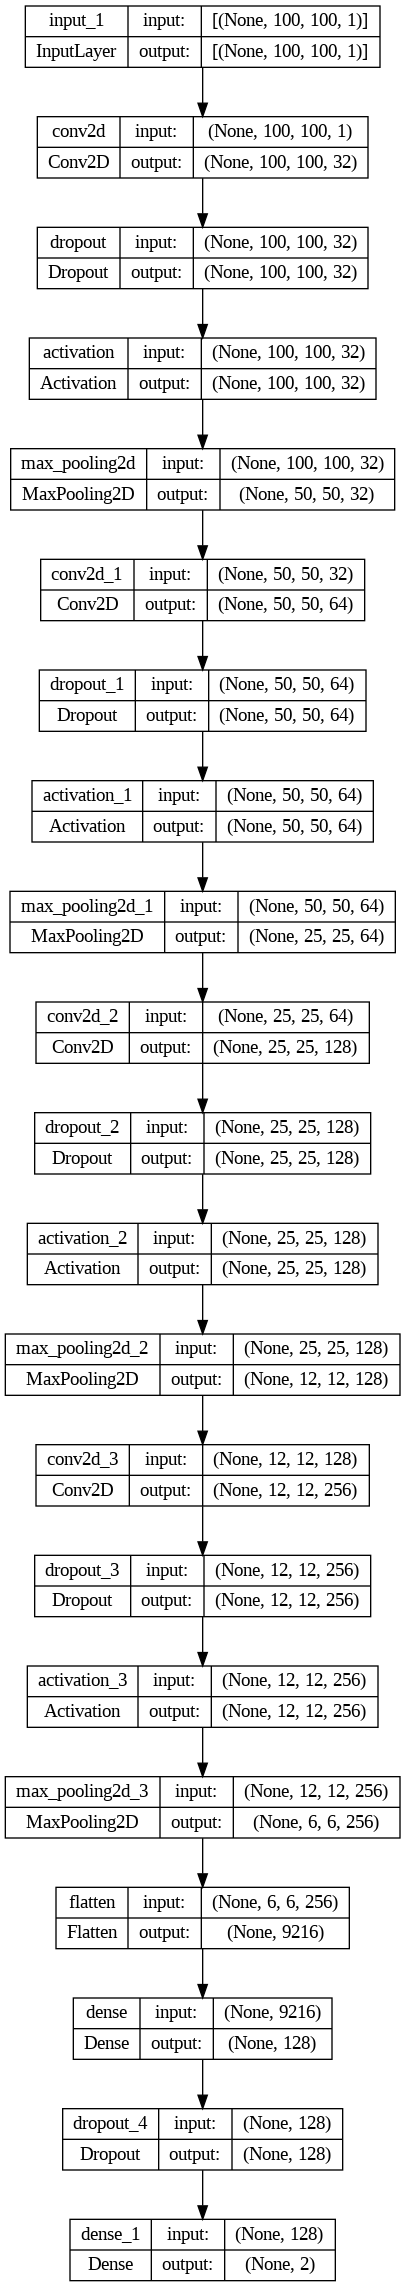

In [15]:
tf.keras.utils.plot_model(model,'model.png',show_shapes = True)

In [16]:
save = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,callbacks=[callback_list])

Epoch 1/20
266/266 [==============================] - ETA: 0s - loss: 0.5729 - accuracy: 0.7623
Epoch 1: loss improved from inf to 0.57294, saving model to /content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5
266/266 [==============================] - 314s 1s/step - loss: 0.5729 - accuracy: 0.7623 - val_loss: 0.4014 - val_accuracy: 0.8450
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


266/266 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8754
Epoch 2: loss improved from 0.57294 to 0.35271, saving model to /content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5
266/266 [==============================] - 317s 1s/step - loss: 0.3527 - accuracy: 0.8754 - val_loss: 0.3672 - val_accuracy: 0.8652
Epoch 3/20
266/266 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.9011
Epoch 3: loss improved from 0.35271 to 0.30193, saving model to /content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5
266/266 [==============================] - 313s 1s/step - loss: 0.3019 - accuracy: 0.9011 - val_loss: 0.3395 - val_accuracy: 0.8779
Epoch 4/20
266/266 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.9147
Epoch 4: loss improved from 0.30193 to 0.27574, saving model to /content/drive/MyDrive/output_logs/gender_detection_model/gender_model.h5
266/266 [==============================] - 31

5/5 [==============================] - 24s 4s/step
Normalized confusion matrix


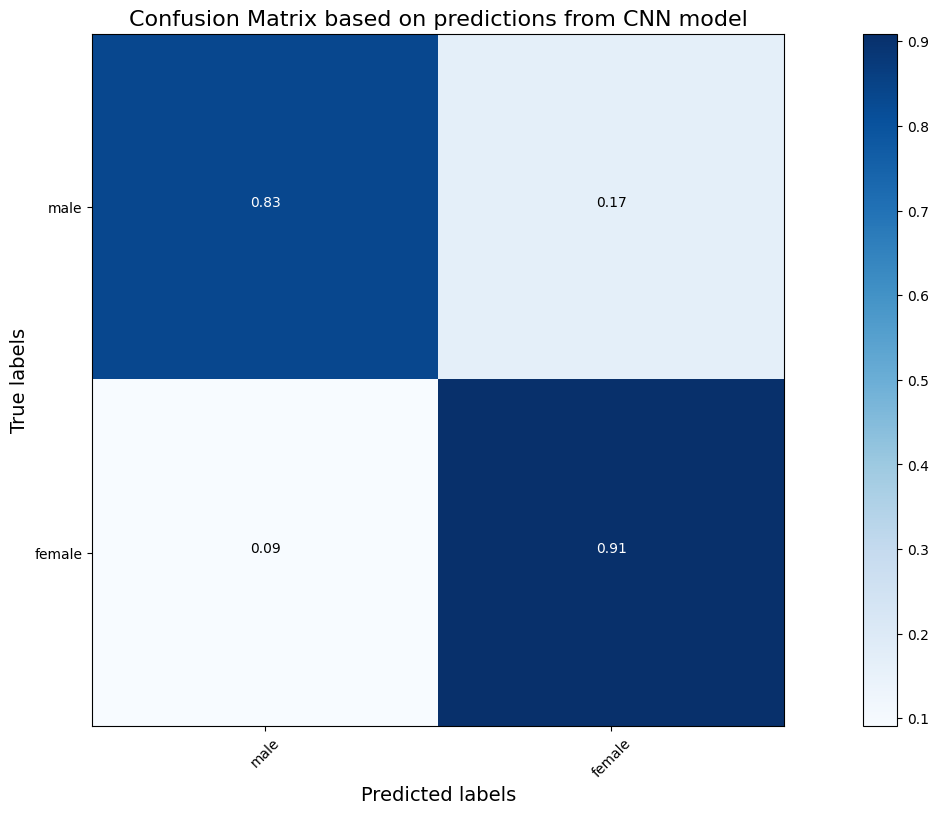

In [27]:
num_classes = 2
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

test_df = pd.read_csv("/content/drive/MyDrive/PPPO/gender_detection/test.csv")
test_df['target'] = test_df['gender'].map(class_labels_reassign)
test_labels_list = list(test_df['target'])
test_filenames_list = list(test_df['image_name'])
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

# Generating predictions from the model above.
final_pred = model.predict(test_dataset)
final_pred = final_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_labels_list, final_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/MyDrive/output_logs/age_detection_model/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['male', 'female']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()